In [816]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [824]:
def compare_plots_to_parametr_row(self, column_y: int) -> None:     # Строит графики зависимости по всем параметрам с привязкой к column_y (индекс)
    num_plots = len(self.columns)
    ncols = 5
    nrows = (num_plots + ncols - 1) // ncols

    plt.figure(figsize=(ncols * 3, nrows * 3))

    for idx, i in enumerate(self.columns[:-1]):
        plt.subplot(nrows, ncols, idx + 1)
        title_y = self.columns[column_y]
        plt.title("{} vs. \n{}".format(i, title_y), fontsize=13)
        sns.regplot(x=self[i], y=self[title_y])
        plt.grid(True)
        plt.xlabel(i, fontsize=11)
        plt.ylabel(title_y, fontsize=11)

    plt.tight_layout()
    plt.show()

def top_correlations_to_parametr(self, top_n: int, num_column: int) -> None:  # Выводит top_n корреляционных пар с привязкой к to_column
    correlation_matrix = self.corr()
    to_column = self.columns[num_column]
    correlation_pairs = correlation_matrix[[to_column]].reset_index()
    correlation_pairs.columns = ['Variable', 'Correlation']
    correlation_pairs = correlation_pairs[correlation_pairs['Variable'] != to_column]
    correlation_pairs['Abs Correlation'] = correlation_pairs['Correlation'].abs()
    top_correlations = correlation_pairs.sort_values(by='Abs Correlation', ascending=False)
    for i in range(min(top_n, len(top_correlations))):
        row = top_correlations.iloc[i]
        print(f"{i + 1}. {row['Variable']} AND {to_column}: {row['Correlation']:.2f}")

def correlation_matrix(self) -> None:    # Строит стандартную корреляционную матрицу
    plt.subplots(figsize=(10, 8))
    sns.heatmap(self.corr(), cmap='RdBu', annot=True, fmt=".2f", annot_kws={"size": 10, "ha": "center", "va": "center"})
    plt.xticks(range(len(self.corr().columns)), self.corr().columns);
    plt.yticks(range(len(self.corr().columns)), self.corr().columns)
    plt.title("Корреляционная матрица", fontsize=16)
    plt.show()

def top_correlations(self, top_n: int) -> None:        # Выводит top_n корреляционных пар
    correlation_matrix = self.corr()
    correlation_pairs = correlation_matrix.unstack()
    correlation_pairs = correlation_pairs.reset_index()
    correlation_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
    correlation_pairs = correlation_pairs[correlation_pairs['Variable 1'] != correlation_pairs['Variable 2']]
    correlation_pairs['Ordered Pair'] = correlation_pairs.apply(lambda x: tuple(sorted([x['Variable 1'], x['Variable 2']])), axis='columns')
    correlation_pairs = correlation_pairs.drop_duplicates(subset=['Ordered Pair'])
    correlation_pairs['Abs Correlation'] = correlation_pairs['Correlation'].abs()
    top_correlations = correlation_pairs.sort_values(by='Abs Correlation', ascending=False)
    for i in range(top_n):
      row = top_correlations.iloc[i]
      print(f"{i + 1}. {row['Variable 1']} AND {row['Variable 2']}: {row['Correlation']:.2f}")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Titanic

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
df = pd.DataFrame(df)
for column in df.select_dtypes(include=['object']).columns:
    df[column], unique = pd.factorize(df[column])

In [ ]:
df_dropna = df.dropna()

In [ ]:
X_for_age = df_dropna.iloc[:, [2, 4, 6, 7, 9]].values
y_for_age = df_dropna.iloc[:, 5].values

X_train, X_test, y_train, y_test = train_test_split(X_for_age, y_for_age, train_size = 0.8, random_state=3)

In [ ]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=0)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
mae_train = mean_absolute_error(y_pred_train, y_train)
mae_test = mean_absolute_error(y_pred_test, y_test)
print(f'{mae_train}, {mae_test}')

8.280687012062687, 9.324366068213552


In [ ]:
predicted_ages = model.predict(X_for_age)
#df.loc[df['Age'].isna(), 'Age'] = predicted_ages[df.loc[df['Age'].isna()].index]

In [ ]:
predicted_ages_pd = pd.DataFrame({
    'Actual_Age': df_dropna['Age'],
    'Predicted_Age': predicted_ages,
})

predicted_ages_pd['Difference'] = predicted_ages_pd['Predicted_Age'] - predicted_ages_pd['Actual_Age']

predicted_ages_pd.describe()

,Actual_Age,Predicted_Age,Difference
count,714.000000,714.000000,714.000000
mean,29.699118,29.784801,0.085683
std,14.526497,8.776034,10.932660
min,0.420000,5.365325,-42.934044
25%,20.125000,25.428895,-6.139897
50%,28.000000,29.405507,1.005430
75%,38.000000,34.645753,7.545995
max,80.000000,51.045275,29.100446


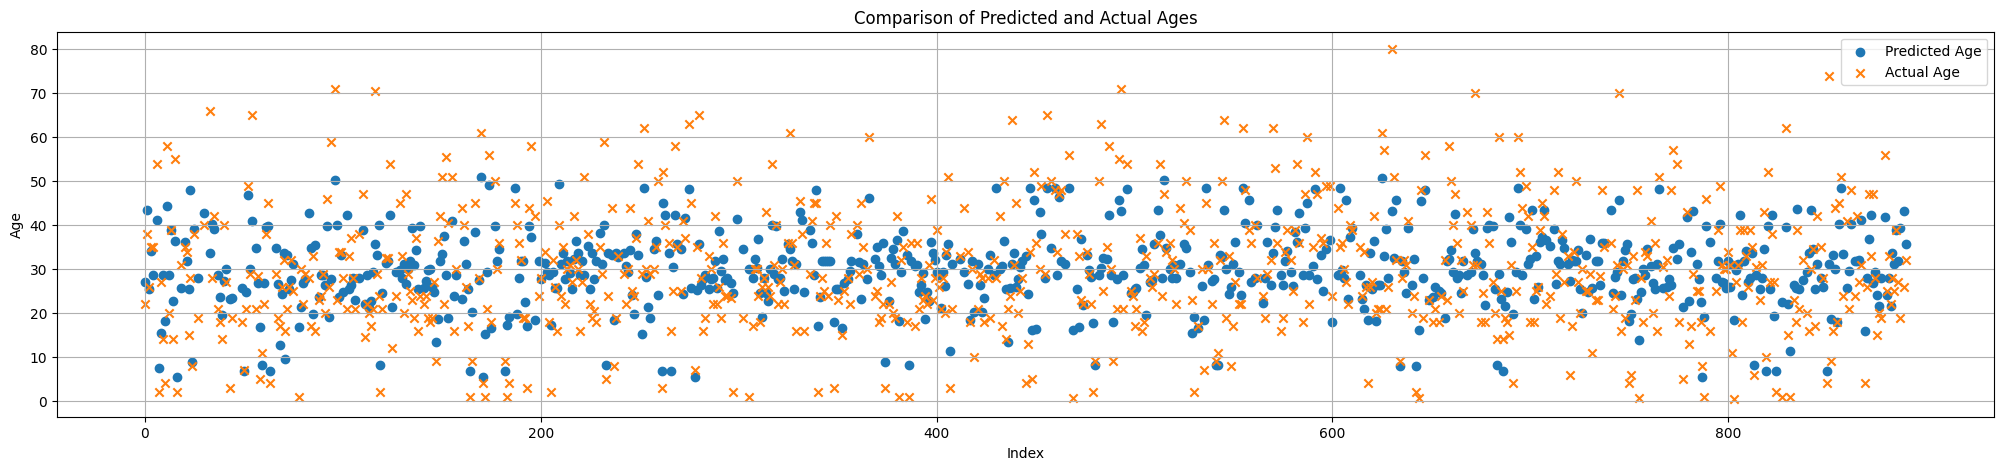

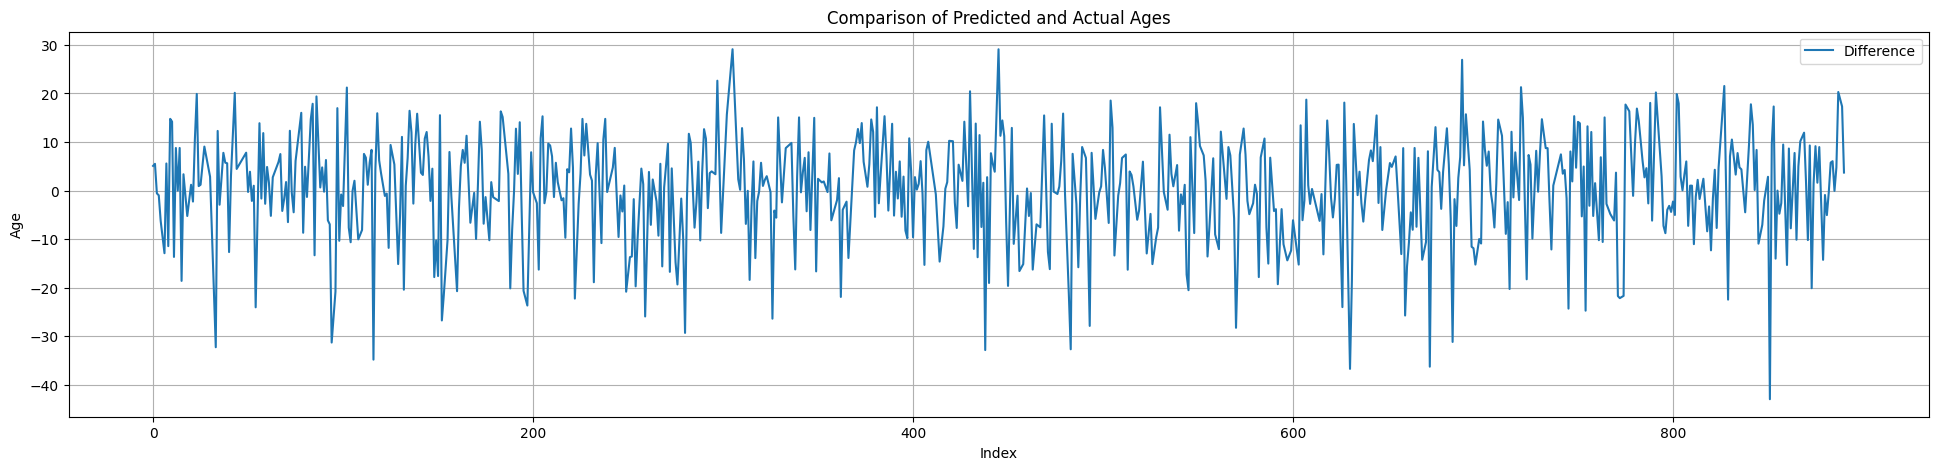

In [ ]:
plt.figure(figsize=(25, 5))
plt.scatter(predicted_ages_pd.index, predicted_ages_pd['Predicted_Age'], label='Predicted Age', marker='o')
plt.scatter(predicted_ages_pd.index, predicted_ages_pd['Actual_Age'], label='Actual Age', marker='x')
plt.xlabel('Index')
plt.ylabel('Age')
plt.title('Comparison of Predicted and Actual Ages')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(24, 5))
plt.plot(predicted_ages_pd.index, predicted_ages_pd['Difference'], label='Difference')
plt.xlabel('Index')
plt.ylabel('Age')
plt.title('Comparison of Predicted and Actual Ages')
plt.legend()
plt.grid()
plt.show()

In [760]:
X = df_dropna.iloc[:, [2, 4, 5, 6, 7]].values
X_norm = df_dropna.iloc[:, [2, 4, 5, 6, 7, 9]].values
scaler = StandardScaler()
X_norm[:, [2, 5]] = scaler.fit_transform(X_norm[:, [2, 5]])

In [682]:
km_scores= []
km_silhouette = []
db_score = []
for i in range(2,100):
    km = KMeans(n_clusters=i, random_state=0).fit(X)
    preds = km.predict(X)

    print("Score for number of cluster(s) {}: {}".format(i,km.score(X)))
    km_scores.append(-km.score(X))

    silhouette = silhouette_score(X,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

    db = davies_bouldin_score(X,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    print("------------------------------------------------------------------")

Score for number of cluster(s) 2: -2478.333800140787
Silhouette score for number of cluster(s) 2: 0.3061513268936765
Davies Bouldin score for number of cluster(s) 2: 1.5020939614970443
------------------------------------------------------------------
Score for number of cluster(s) 3: -1938.5307922251882
Silhouette score for number of cluster(s) 3: 0.34267529746792325
Davies Bouldin score for number of cluster(s) 3: 1.248964342384115
------------------------------------------------------------------
Score for number of cluster(s) 4: -1603.820495284148
Silhouette score for number of cluster(s) 4: 0.3322133055741998
Davies Bouldin score for number of cluster(s) 4: 1.1616586190888931
------------------------------------------------------------------
Score for number of cluster(s) 5: -1352.202127333511
Silhouette score for number of cluster(s) 5: 0.3421970096487814
Davies Bouldin score for number of cluster(s) 5: 1.126678582213642
-----------------------------------------------------------

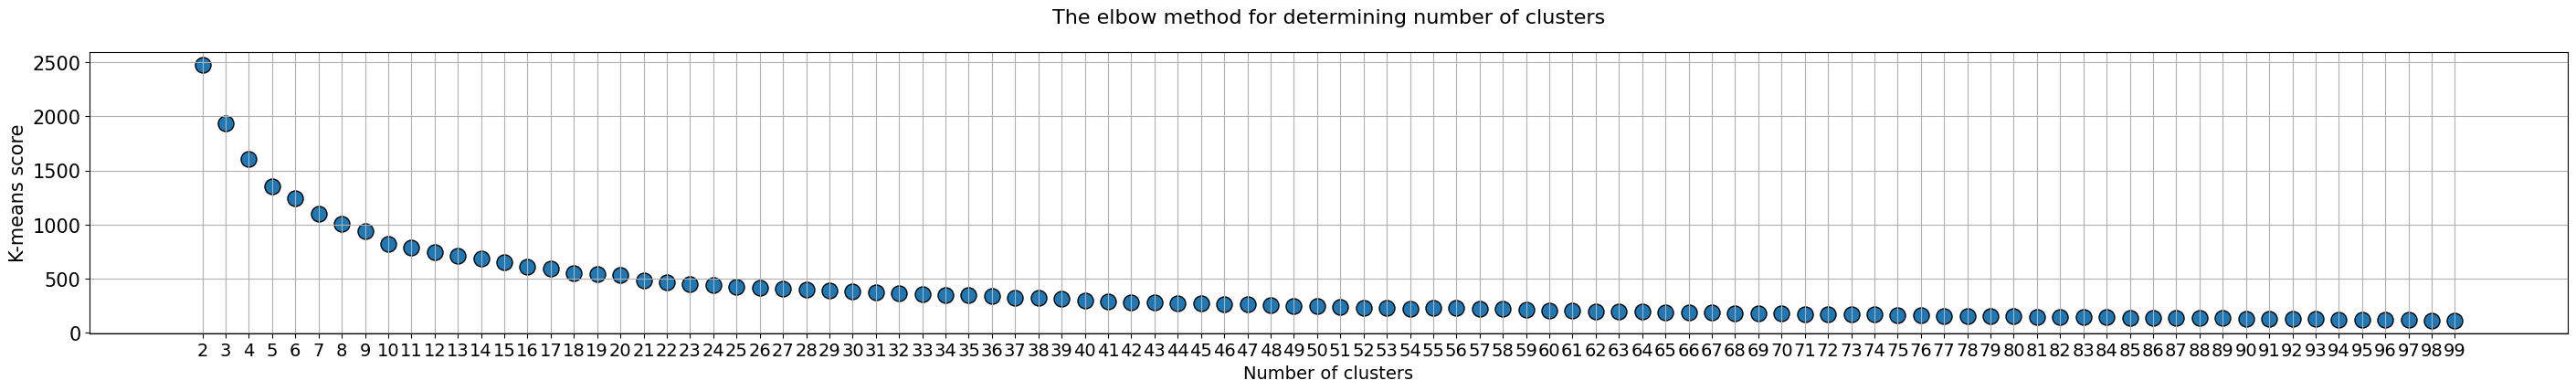

In [683]:
plt.figure(figsize=(35,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,100)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,100)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

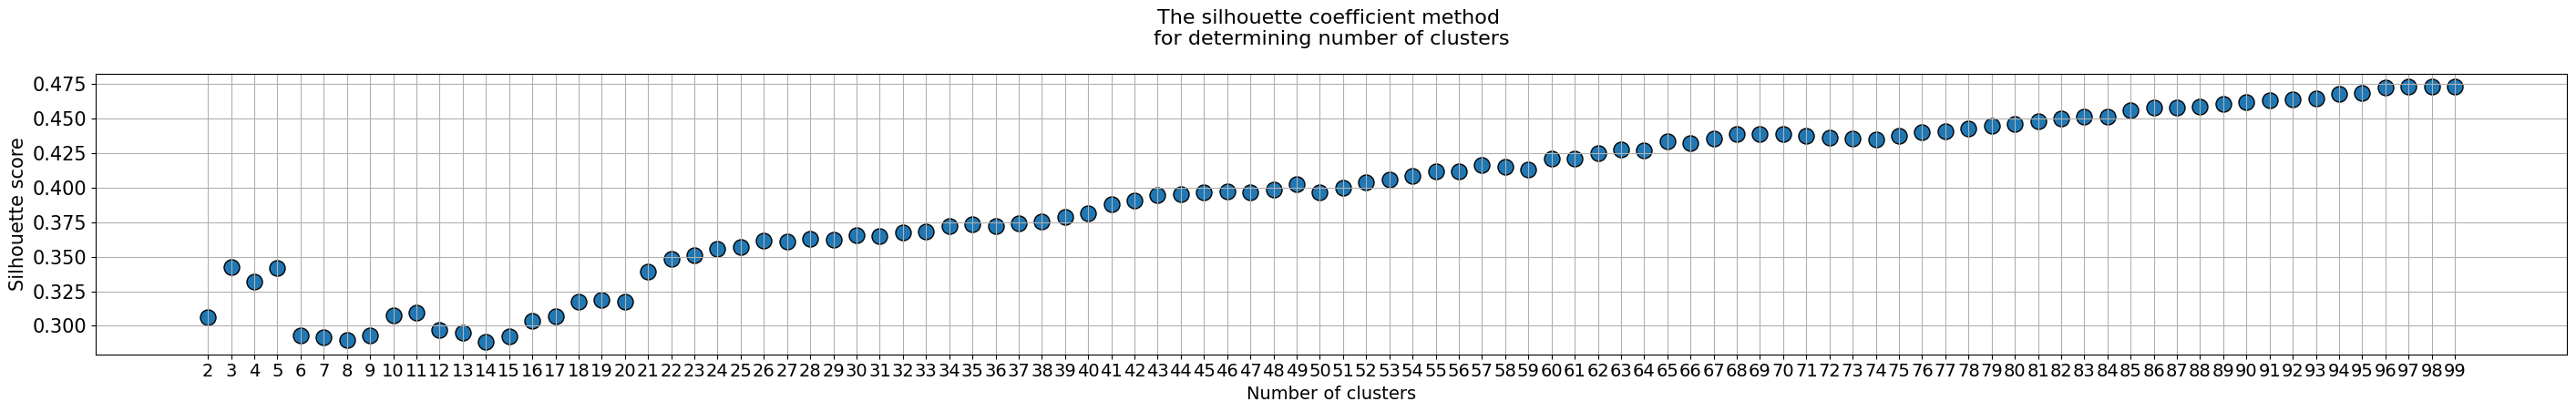

In [684]:
plt.figure(figsize=(35,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,100)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,100)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

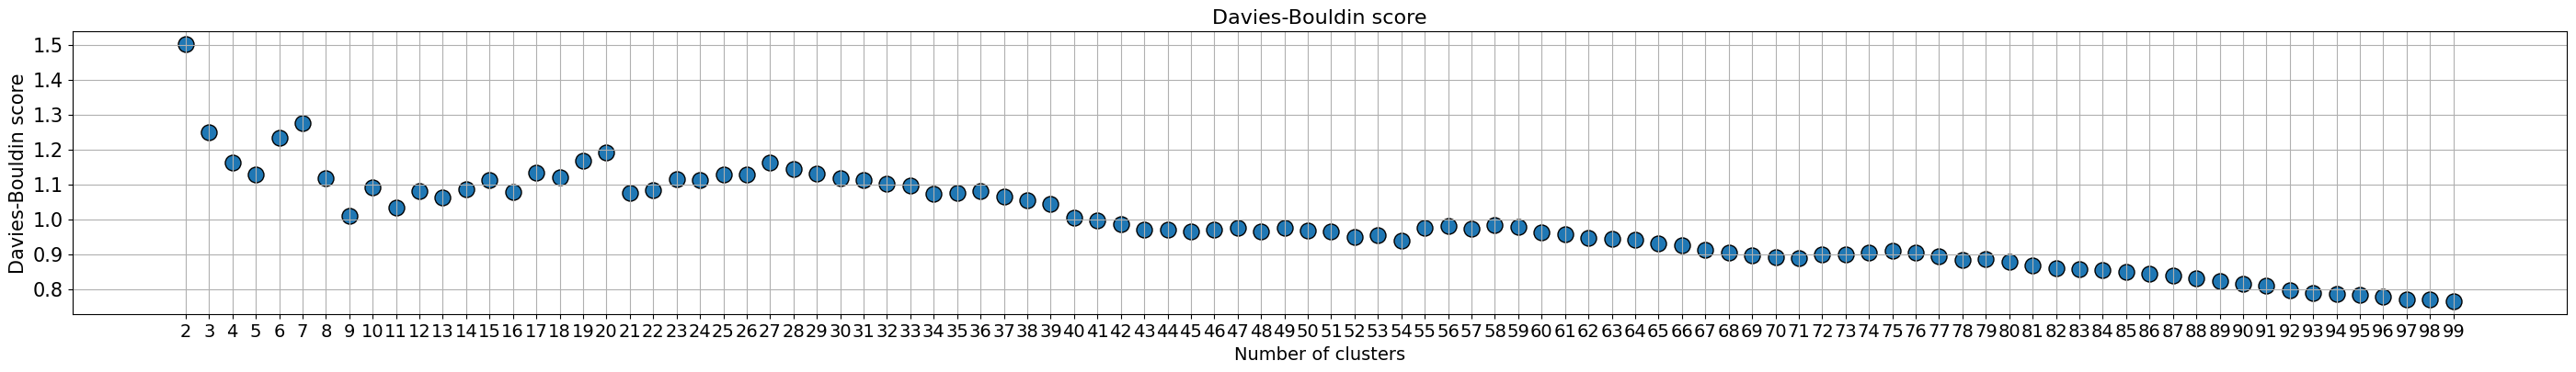

In [685]:
plt.figure(figsize=(35,4))
plt.title("Davies-Bouldin score",fontsize=16)
plt.scatter(x=[i for i in range(2,100)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Davies-Bouldin score",fontsize=15)
plt.xticks([i for i in range(2,100)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [686]:
model = KMeans(n_clusters=99, random_state=0).fit(X)
preds = model.predict(X)
df_cluster = df_dropna.copy()
df_cluster["Cluster"] = preds
df_cluster.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cluster
0,1,0,3,0,0,22.0,1,0,0,7.2500,-1,0,43
1,2,1,1,1,1,38.0,1,0,1,71.2833,0,1,1
2,3,1,3,2,1,26.0,0,0,2,7.9250,-1,0,79
3,4,1,1,3,1,35.0,1,0,3,53.1000,1,0,1
4,5,0,3,4,0,35.0,0,0,4,8.0500,-1,0,8


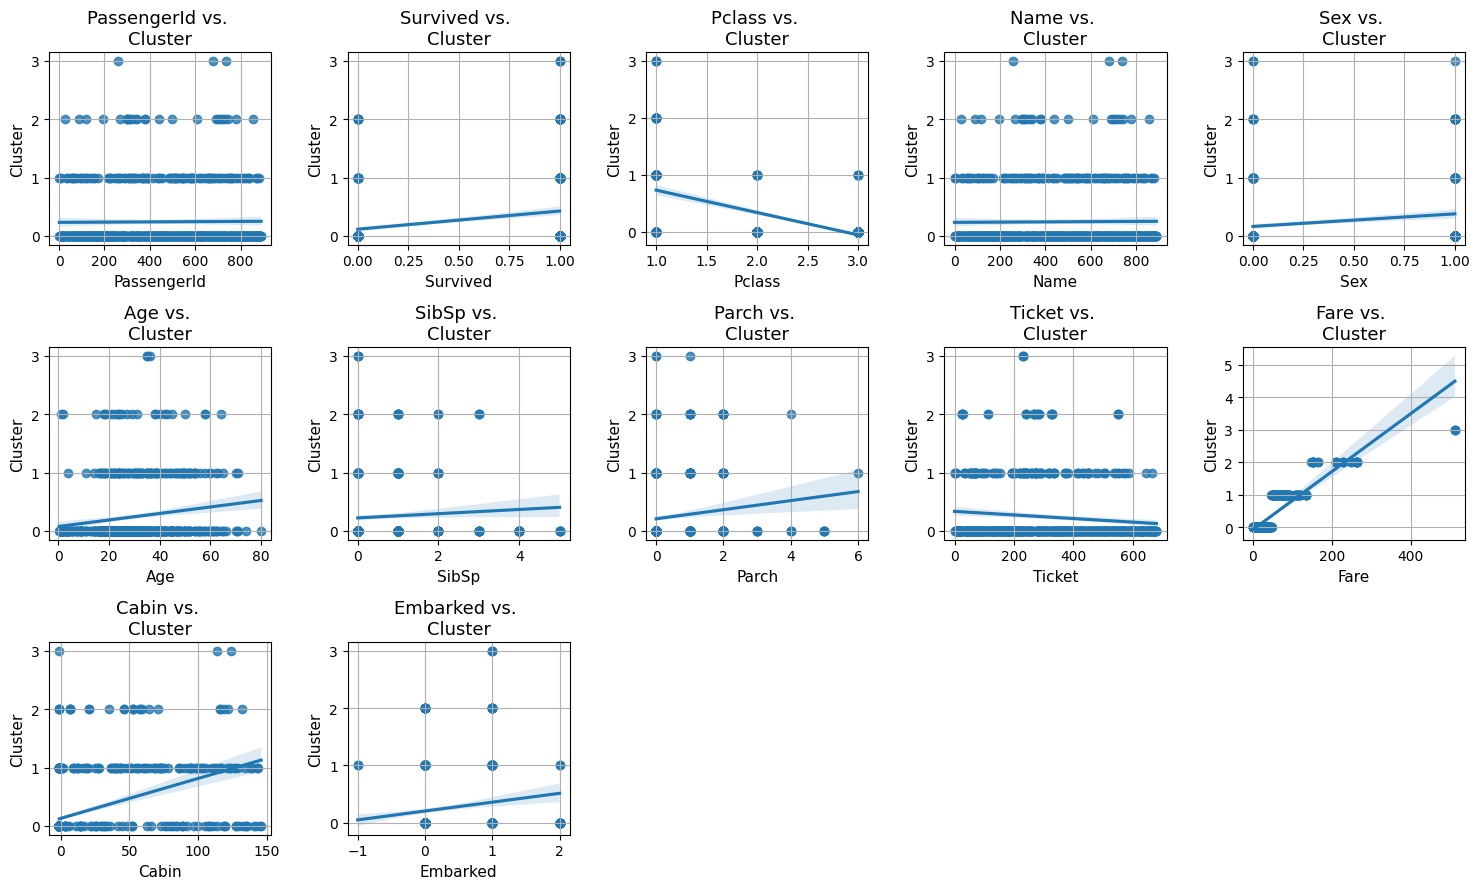

In [669]:
compare_plots_to_parametr_row(df_cluster, 12)

In [687]:
top_correlations_to_parametr(df_cluster, 12, 12)

1. Sex AND Cluster: 0.28
2. Parch AND Cluster: 0.27
3. Pclass AND Cluster: -0.22
4. Survived AND Cluster: 0.20
5. Ticket AND Cluster: -0.18
6. SibSp AND Cluster: 0.16
7. Cabin AND Cluster: 0.14
8. Fare AND Cluster: 0.10
9. PassengerId AND Cluster: -0.08
10. Name AND Cluster: -0.08
11. Age AND Cluster: -0.02
12. Embarked AND Cluster: -0.02


<ipython-input-688-f6051fc97f3e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


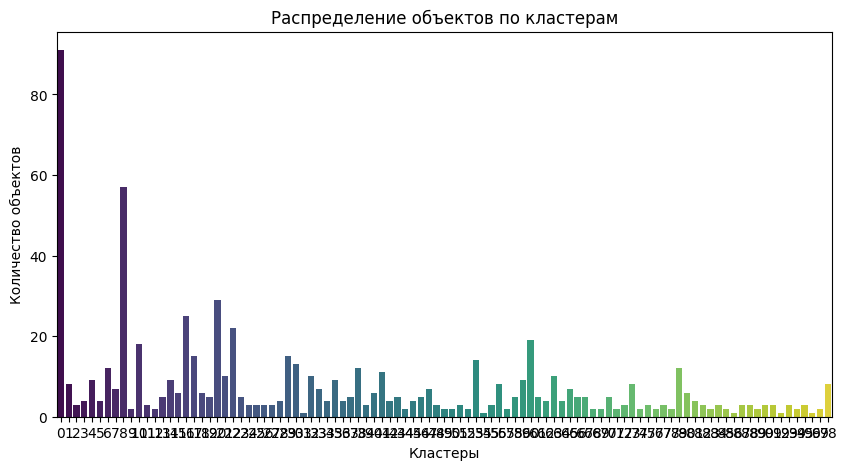

In [688]:
unique, counts = np.unique(preds, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique, y=counts, palette="viridis")

plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.xticks(unique)
plt.show()

In [772]:
db_silhouette = []
db_score = []

min_samples_values = [1,2,3,4,5,6,7,8,9,10]
eps_values = []
for k in range(1,30,1):
    epsilon = k/10
    eps_values.append(epsilon)

for eps in eps_values:
    for min_samples in min_samples_values:
        # Применение DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples)
        preds = db.fit_predict(X)

        # Проверка наличия кластеров
        if len(set(preds)) > 1:  # Убедитесь, что есть более одного кластера
            silhouette = silhouette_score(X, preds)
            db_silhouette.append(silhouette)
            print(f"Silhouette score for eps={eps}, min_samples={min_samples}: {silhouette}")

            db_index = davies_bouldin_score(X, preds)
            db_score.append(db_index)
            print(f"Davies Bouldin score for eps={eps}, min_samples={min_samples}: {db_index}")
        else:
            print(f"Insufficient clusters for eps={eps}, min_samples={min_samples}")

        print("------------------------------------------------------------------")

Silhouette score for eps=0.1, min_samples=1: 0.5070028011204482
Davies Bouldin score for eps=0.1, min_samples=1: 0.0
------------------------------------------------------------------
Silhouette score for eps=0.1, min_samples=2: 0.06047983345077575
Davies Bouldin score for eps=0.1, min_samples=2: 3.0366788593061145
------------------------------------------------------------------
Silhouette score for eps=0.1, min_samples=3: -0.19522628743333043
Davies Bouldin score for eps=0.1, min_samples=3: 3.1487852378711603
------------------------------------------------------------------
Silhouette score for eps=0.1, min_samples=4: -0.3568273448183459
Davies Bouldin score for eps=0.1, min_samples=4: 3.1521597641269192
------------------------------------------------------------------
Silhouette score for eps=0.1, min_samples=5: -0.3533559531100102
Davies Bouldin score for eps=0.1, min_samples=5: 3.404749750769861
------------------------------------------------------------------
Silhouette score

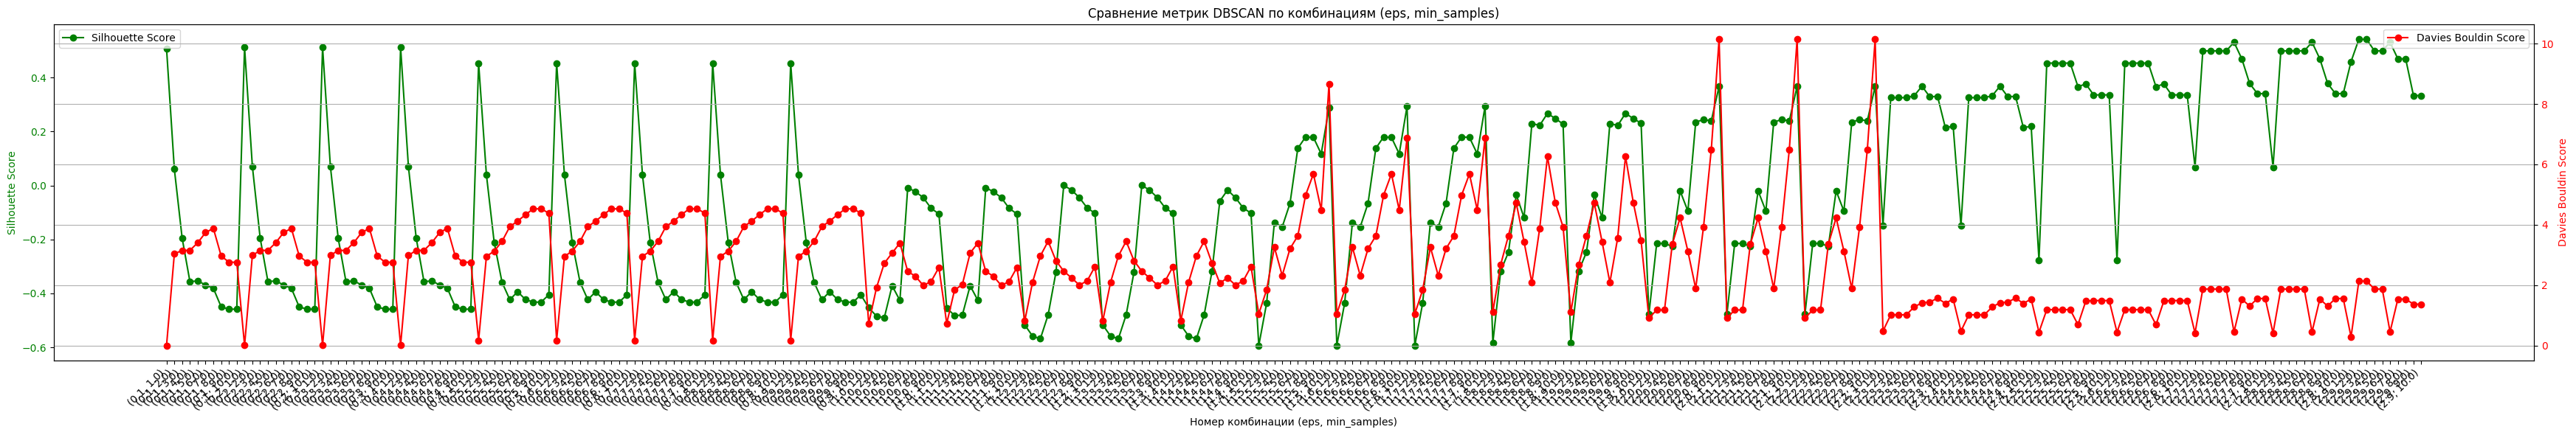

In [773]:
eps_min_samples_pairs = [(eps, min_samples) for eps in eps_values for min_samples in min_samples_values]
eps_min_samples_pairs = np.array(eps_min_samples_pairs)

fig, ax1 = plt.subplots(figsize=(35, 6))

ax1.plot(range(len(db_silhouette)), db_silhouette, 'g-o', label='Silhouette Score')
ax1.set_xlabel('Номер комбинации (eps, min_samples)')
ax1.set_ylabel('Silhouette Score', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_xticks(range(len(db_silhouette)))
ax1.set_xticklabels([f'({eps}, {min_samples})' for eps, min_samples in eps_min_samples_pairs], rotation=45, ha='right')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(db_score)), db_score, 'r-o', label='Davies Bouldin Score')
ax2.set_ylabel('Davies Bouldin Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.title('Сравнение метрик DBSCAN по комбинациям (eps, min_samples)')
plt.grid()
plt.tight_layout()
plt.show()

In [792]:
model = DBSCAN(eps=2.3, min_samples=10)
preds = model.fit_predict(X)
df_cluster = df_dropna.copy()
df_cluster["Cluster"] = preds
df_cluster.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cluster
0,1,0,3,0,0,22.0,1,0,0,7.2500,-1,0,0
1,2,1,1,1,1,38.0,1,0,1,71.2833,0,1,0
2,3,1,3,2,1,26.0,0,0,2,7.9250,-1,0,0
3,4,1,1,3,1,35.0,1,0,3,53.1000,1,0,0
4,5,0,3,4,0,35.0,0,0,4,8.0500,-1,0,0


In [793]:
top_correlations_to_parametr(df_cluster, 12, 12)

1. Age AND Cluster: -0.52
2. SibSp AND Cluster: 0.40
3. Ticket AND Cluster: -0.15
4. Pclass AND Cluster: 0.15
5. Parch AND Cluster: 0.14
6. Cabin AND Cluster: -0.08
7. Survived AND Cluster: 0.07
8. Fare AND Cluster: -0.05
9. Sex AND Cluster: 0.04
10. PassengerId AND Cluster: -0.03
11. Name AND Cluster: -0.03
12. Embarked AND Cluster: 0.01


<ipython-input-794-f6051fc97f3e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


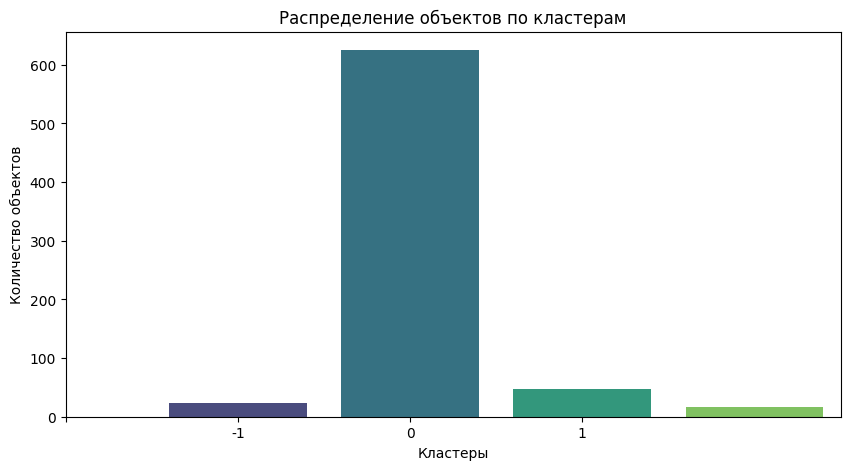

In [794]:
unique, counts = np.unique(preds, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique, y=counts, palette="viridis")

plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.xticks(unique)
plt.show()

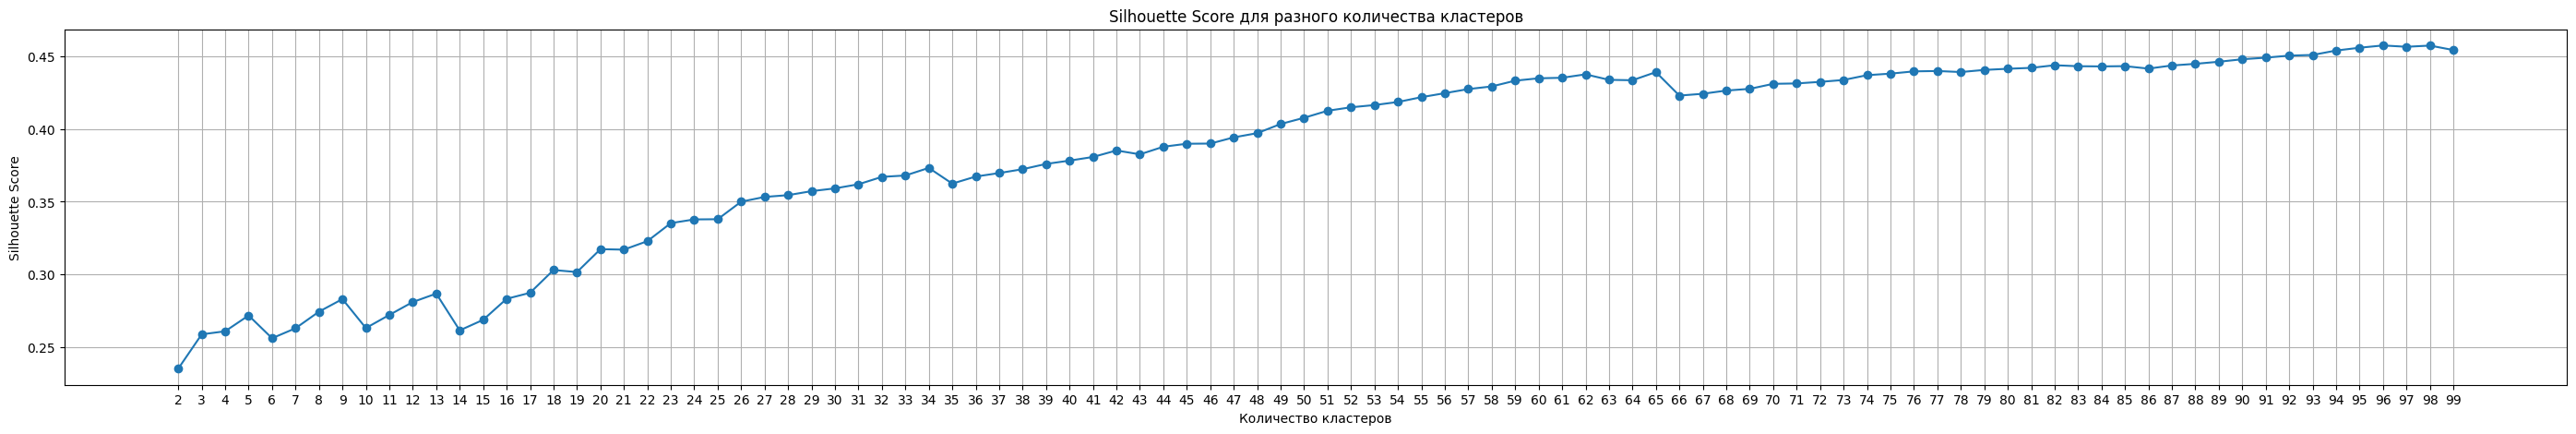

In [726]:
def compute_silhouette(X, n_clusters):
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    return silhouette_avg

silhouette_scores = []
n_clusters_range = range(2, 100)
for n_clusters in n_clusters_range:
    silhouette_avg = compute_silhouette(X, n_clusters)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(35, 5))
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score для разного количества кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.xticks(n_clusters_range)
plt.grid()
plt.show()

In [752]:
model = AgglomerativeClustering(n_clusters=13)
preds = model.fit_predict(X)
df_cluster = df_dropna.copy()
df_cluster["Cluster"] = preds
df_cluster.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cluster
0,1,0,3,0,0,22.0,1,0,0,7.2500,-1,0,10
1,2,1,1,1,1,38.0,1,0,1,71.2833,0,1,9
2,3,1,3,2,1,26.0,0,0,2,7.9250,-1,0,0
3,4,1,1,3,1,35.0,1,0,3,53.1000,1,0,9
4,5,0,3,4,0,35.0,0,0,4,8.0500,-1,0,0


In [753]:
top_correlations_to_parametr(df_cluster, 12, 12)

1. SibSp AND Cluster: 0.58
2. Pclass AND Cluster: -0.33
3. Ticket AND Cluster: -0.27
4. Fare AND Cluster: 0.25
5. Cabin AND Cluster: 0.24
6. Parch AND Cluster: 0.22
7. Sex AND Cluster: 0.20
8. Age AND Cluster: 0.15
9. Survived AND Cluster: 0.12
10. Embarked AND Cluster: 0.10
11. PassengerId AND Cluster: -0.07
12. Name AND Cluster: -0.07


<ipython-input-754-f6051fc97f3e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


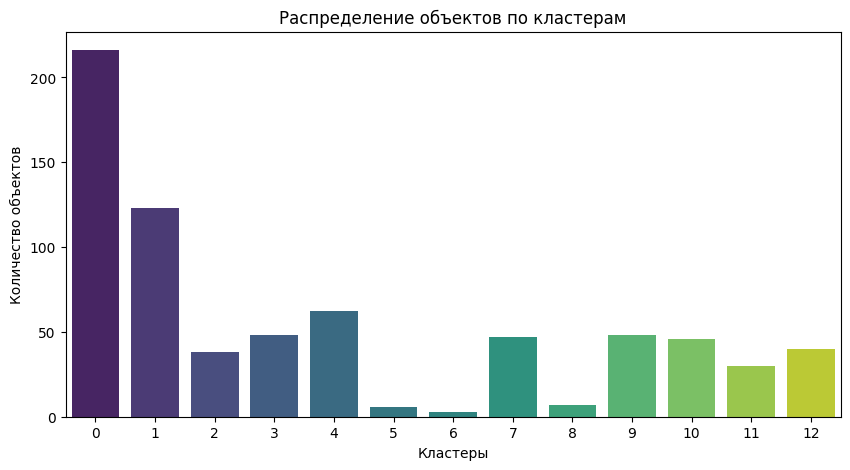

In [754]:
unique, counts = np.unique(preds, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique, y=counts, palette="viridis")

plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.xticks(unique)
plt.show()

# Boston

In [798]:
df2 = pd.read_csv('/content/drive/MyDrive/BostonHousing.csv')

In [800]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


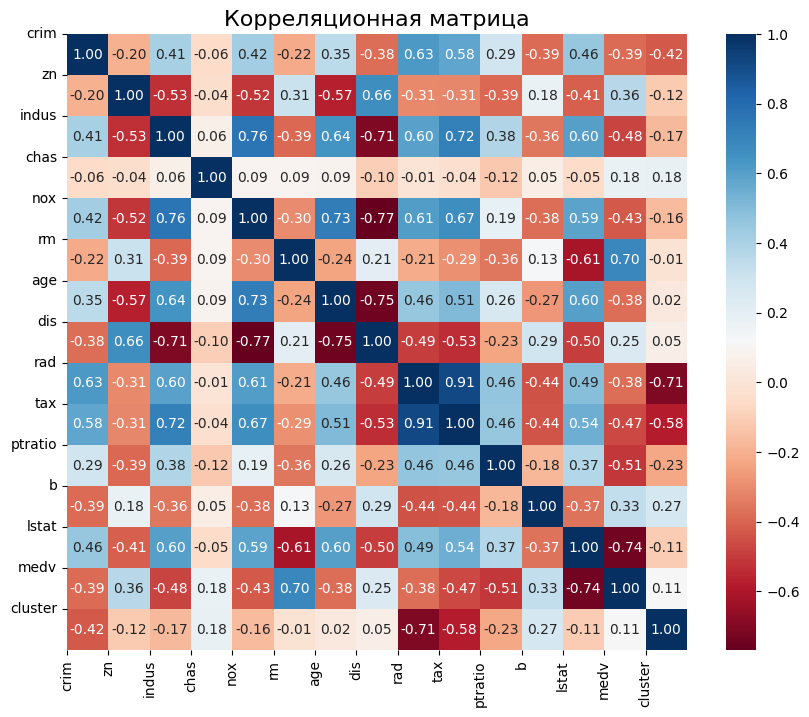

In [822]:
correlation_matrix(df2)

In [828]:
top_correlations(df2, 50)

1. rad AND tax: 0.91
2. nox AND dis: -0.77
3. indus AND nox: 0.76
4. age AND dis: -0.75
5. lstat AND medv: -0.74
6. nox AND age: 0.73
7. indus AND tax: 0.72
8. rad AND cluster: -0.71
9. indus AND dis: -0.71
10. rm AND medv: 0.70
11. nox AND tax: 0.67
12. zn AND dis: 0.66
13. indus AND age: 0.64
14. crim AND rad: 0.63
15. rm AND lstat: -0.61
16. nox AND rad: 0.61
17. indus AND lstat: 0.60
18. age AND lstat: 0.60
19. indus AND rad: 0.60
20. nox AND lstat: 0.59
21. crim AND tax: 0.58
22. tax AND cluster: -0.58
23. zn AND age: -0.57
24. tax AND lstat: 0.54
25. dis AND tax: -0.53
26. zn AND indus: -0.53
27. zn AND nox: -0.52
28. ptratio AND medv: -0.51
29. age AND tax: 0.51
30. dis AND lstat: -0.50
31. dis AND rad: -0.49
32. rad AND lstat: 0.49
33. indus AND medv: -0.48
34. tax AND medv: -0.47
35. rad AND ptratio: 0.46
36. tax AND ptratio: 0.46
37. age AND rad: 0.46
38. crim AND lstat: 0.46
39. rad AND b: -0.44
40. tax AND b: -0.44
41. nox AND medv: -0.43
42. crim AND cluster: -0.42
43. cri

In [829]:
X = df2.drop(['medv', 'nox', 'tax', 'rad', 'indus', 'dis', 'age', 'lstat', 'rm'], axis=1).values
scaler = StandardScaler()
X = scaler.fit_transform(X)

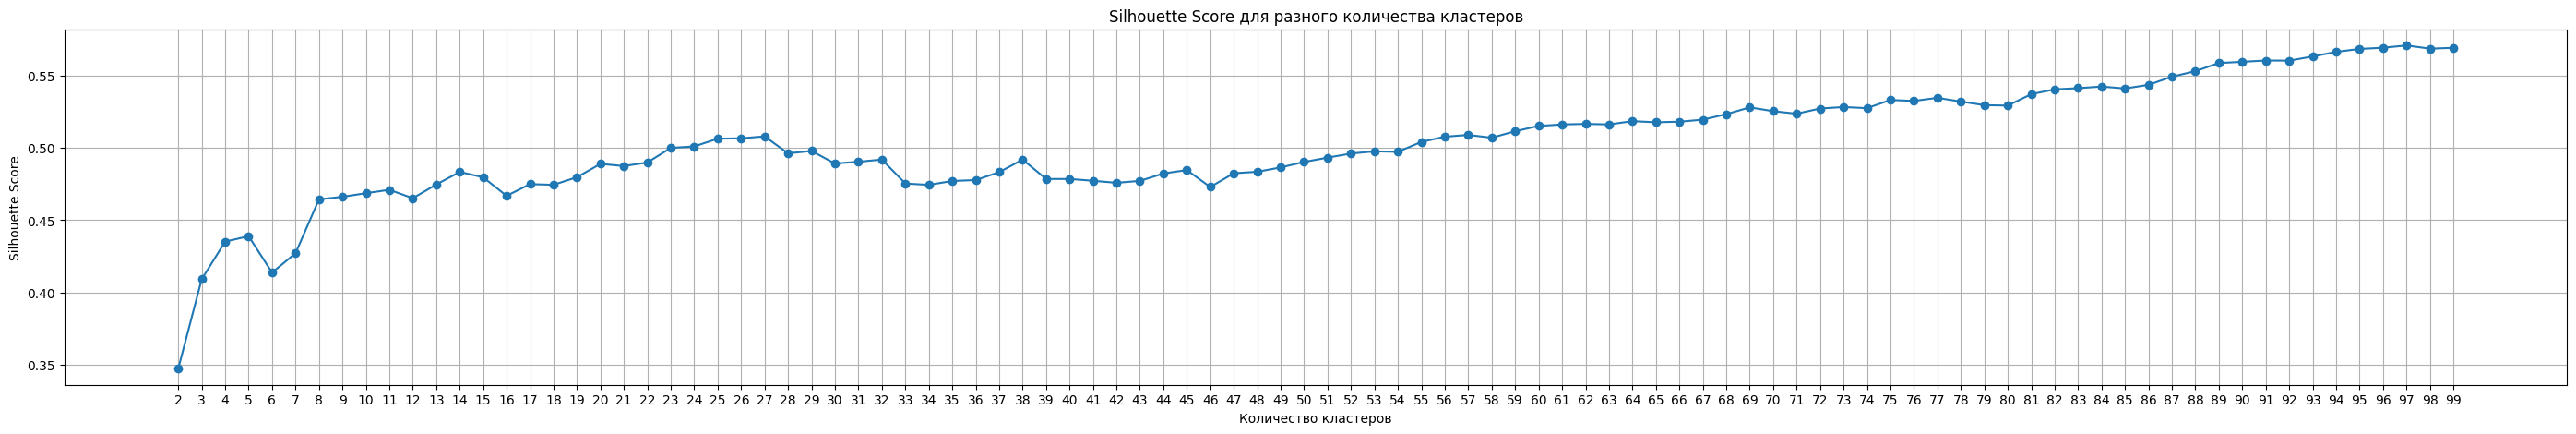

In [830]:
def compute_silhouette(X, n_clusters):
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    return silhouette_avg

silhouette_scores = []
n_clusters_range = range(2, 100)
for n_clusters in n_clusters_range:
    silhouette_avg = compute_silhouette(X, n_clusters)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(35, 5))
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title('Silhouette Score для разного количества кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.xticks(n_clusters_range)
plt.grid()
plt.show()

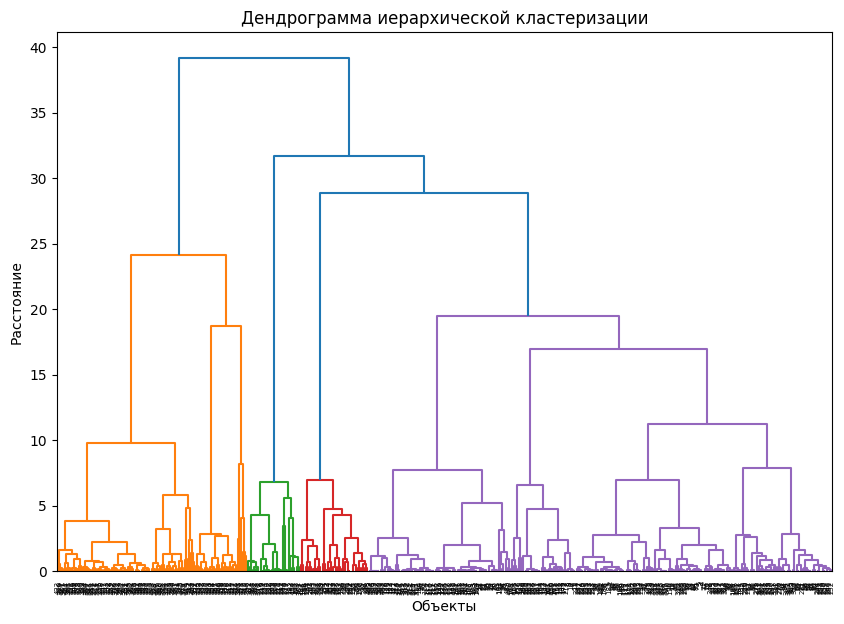

In [831]:
Z = linkage(X, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df2.index, leaf_rotation=90)
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Объекты')
plt.ylabel('Расстояние')
plt.show()

In [839]:
model = AgglomerativeClustering(n_clusters=8)
preds = model.fit_predict(X)
df_cluster = df2.copy()
df_cluster["Cluster"] = preds
df_cluster.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv,cluster,Cluster
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,110,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,87,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,85,0
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,85,0
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,85,0


<ipython-input-840-f6051fc97f3e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


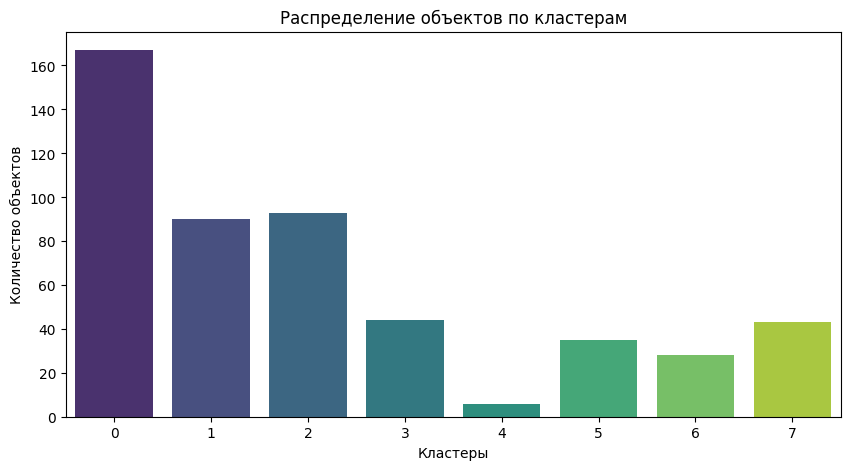

In [840]:
unique, counts = np.unique(preds, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique, y=counts, palette="viridis")

plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.xticks(unique)
plt.show()

In [832]:
km_scores= []
km_silhouette = []
db_score = []
for i in range(2,100):
    km = KMeans(n_clusters=i, random_state=0).fit(X)
    preds = km.predict(X)

    print("Score for number of cluster(s) {}: {}".format(i,km.score(X)))
    km_scores.append(-km.score(X))

    silhouette = silhouette_score(X,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

    db = davies_bouldin_score(X,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    print("------------------------------------------------------------------")

Score for number of cluster(s) 2: -2502.559182882446
Silhouette score for number of cluster(s) 2: 0.43671950988419733
Davies Bouldin score for number of cluster(s) 2: 0.784378408828079
------------------------------------------------------------------
Score for number of cluster(s) 3: -1982.2120745429254
Silhouette score for number of cluster(s) 3: 0.31003462541547894
Davies Bouldin score for number of cluster(s) 3: 1.1068986605831503
------------------------------------------------------------------
Score for number of cluster(s) 4: -1339.9111632002134
Silhouette score for number of cluster(s) 4: 0.4024249543311499
Davies Bouldin score for number of cluster(s) 4: 0.9631727865471634
------------------------------------------------------------------
Score for number of cluster(s) 5: -1124.5912875153156
Silhouette score for number of cluster(s) 5: 0.41302325671388446
Davies Bouldin score for number of cluster(s) 5: 0.9039693763718809
------------------------------------------------------

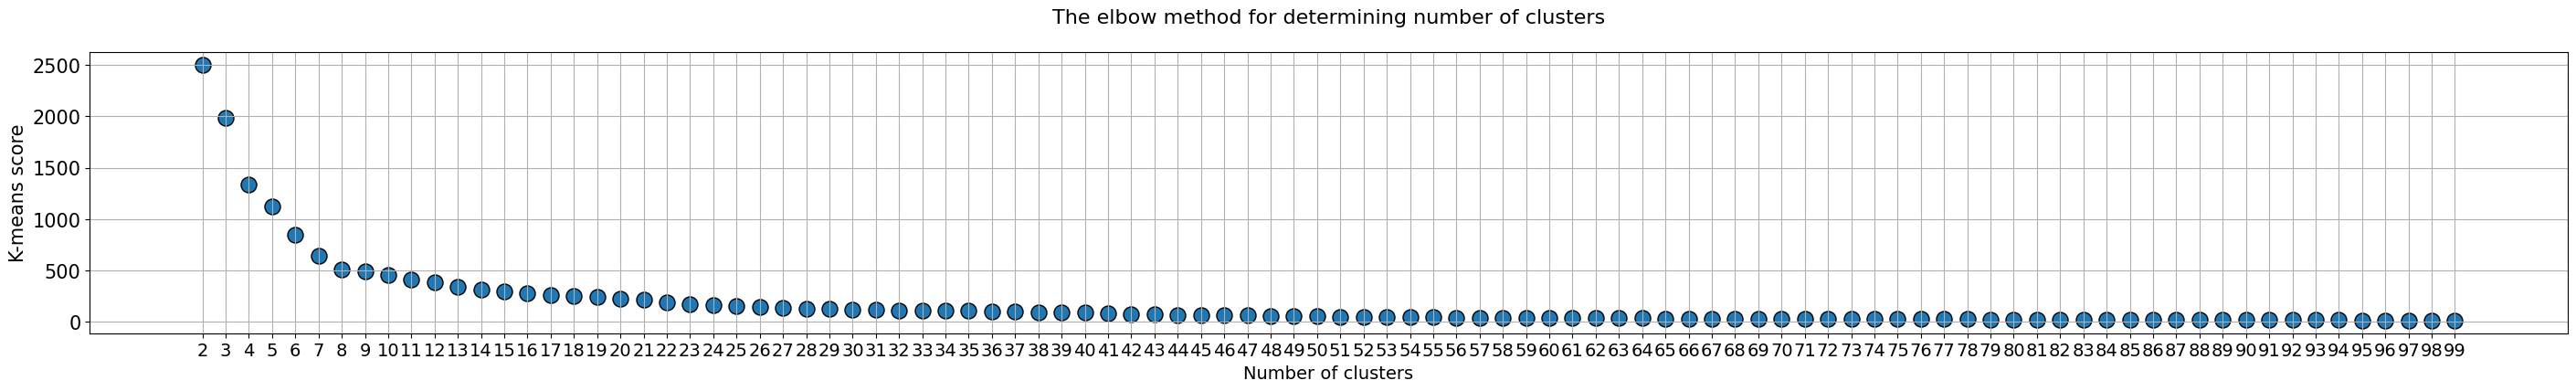

In [833]:
plt.figure(figsize=(35,4))
plt.title("The elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,100)],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,100)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

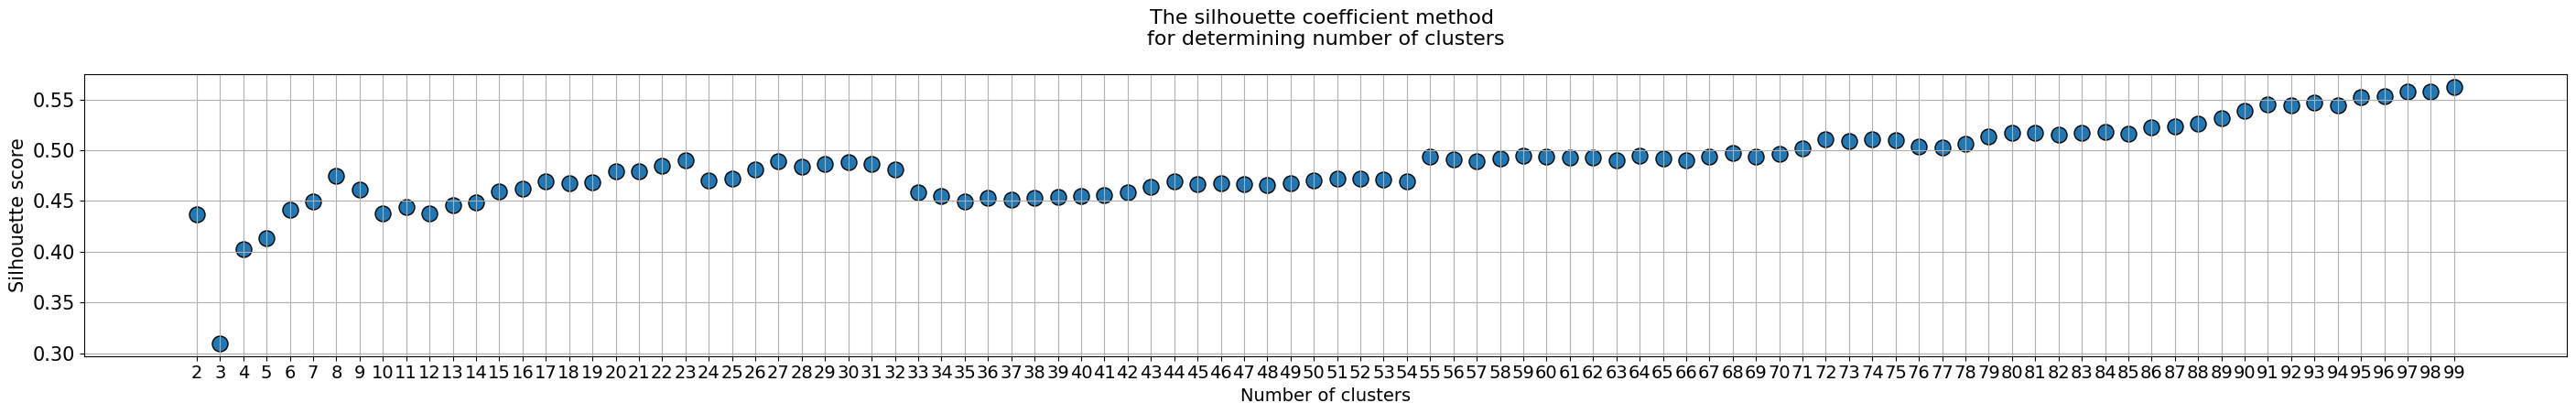

In [834]:
plt.figure(figsize=(35,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,100)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,100)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

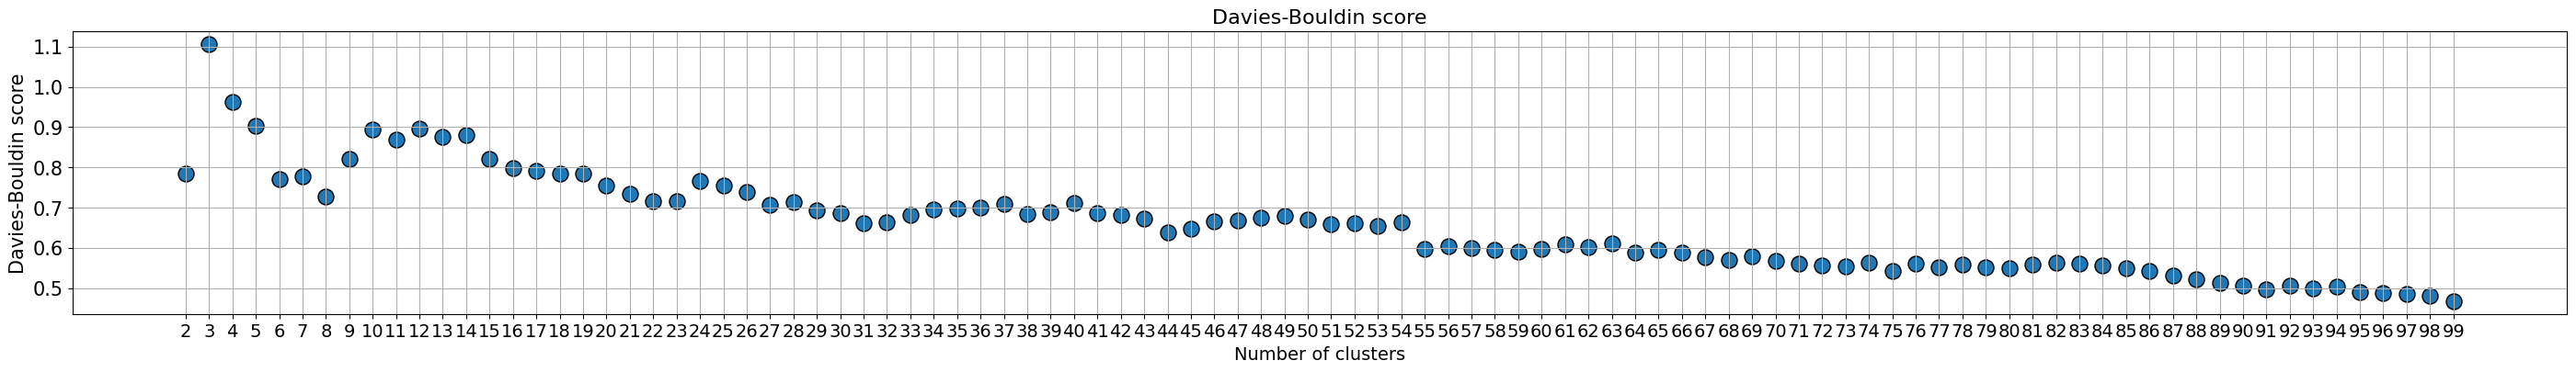

In [835]:
plt.figure(figsize=(35,4))
plt.title("Davies-Bouldin score",fontsize=16)
plt.scatter(x=[i for i in range(2,100)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Davies-Bouldin score",fontsize=15)
plt.xticks([i for i in range(2,100)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

In [836]:
model = KMeans(n_clusters=8)
preds = model.fit_predict(X)
df_cluster = df2.copy()
df_cluster["Cluster"] = preds
df_cluster.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv,cluster,Cluster
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,110,5
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,87,5
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,85,5
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,85,5
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,85,5


<ipython-input-837-f6051fc97f3e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


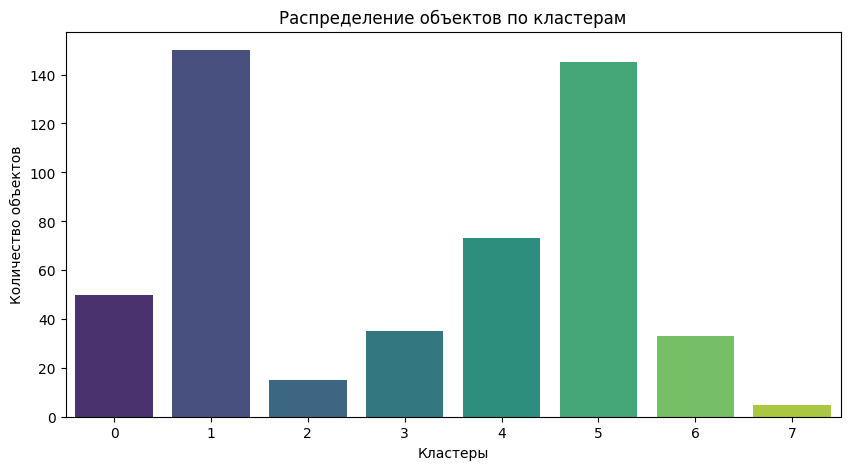

In [837]:
unique, counts = np.unique(preds, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique, y=counts, palette="viridis")

plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.xticks(unique)
plt.show()